# Import Modules

In [2]:
import os
import pkbar
import random
import numpy as np
from PIL import Image, ImageOps
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm
import albumentations as A

import warnings
warnings.filterwarnings('ignore')

In [3]:
import torch  
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchsummary import summary

In [4]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device

device(type='cuda', index=0)

# Dataset

In [5]:
class Dataset:

    def __init__(self, H, W, data_fol, im_list, augmentation=False):
        self.H=H
        self.W=W
        self.im_fol=os.path.join(data_fol, "img")
        self.mask_fol=os.path.join(data_fol, "mask")       

        self.im_list=im_list
        self.N=len(self.im_list) 

        self.augmentation=augmentation
        self.transform = A.Compose([
                A.RandomBrightnessContrast(p=0.5),
            ])

        
    def __len__(self):
        return self.N

    
    def __getitem__(self, index):
        im_name=self.im_list[index]
        mask_name=im_name.split(".")[0]+".ah.ppm"

        im_path=os.path.join(self.im_fol, im_name)
        mask_path=os.path.join(self.mask_fol, mask_name)

        im=Image.open(im_path).resize((self.W, self.H))
        mask=Image.open(mask_path)
        mask=ImageOps.grayscale(mask)
        mask=mask.resize((self.W, self.H))       

        im=np.array(im)/255
        mask=np.array(mask)/255

        if self.augmentation:
            transformed = self.transform(image=im, mask=mask)
            im = transformed['image']
            mask = transformed['mask'] 

        im=np.moveaxis(im, -1, 0)
        im=im.astype(np.float32)
        mask=mask.astype(np.int64)

        return (im, mask)


In [6]:
# train test split

data_fol="data"
im_list=os.listdir("data/img")

H, W= 512, 512   # height-width of finnal image
batch=4

N1=int(len(im_list)*0.8)

train_list=im_list[:N1]
test_list =im_list[N1:]

In [7]:
# generates samples with an image and its mask

train_dataset=Dataset(H, W, data_fol, train_list, augmentation=True)
test_dataset=Dataset(H, W, data_fol, test_list)

In [8]:
# generates data with given batch size

train_generator = torch.utils.data.DataLoader(train_dataset, batch_size=batch, shuffle=True)
test_generator = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

# Data Visualization

In [9]:
data_generator = torch.utils.data.DataLoader(train_dataset, batch_size=1, shuffle=False)

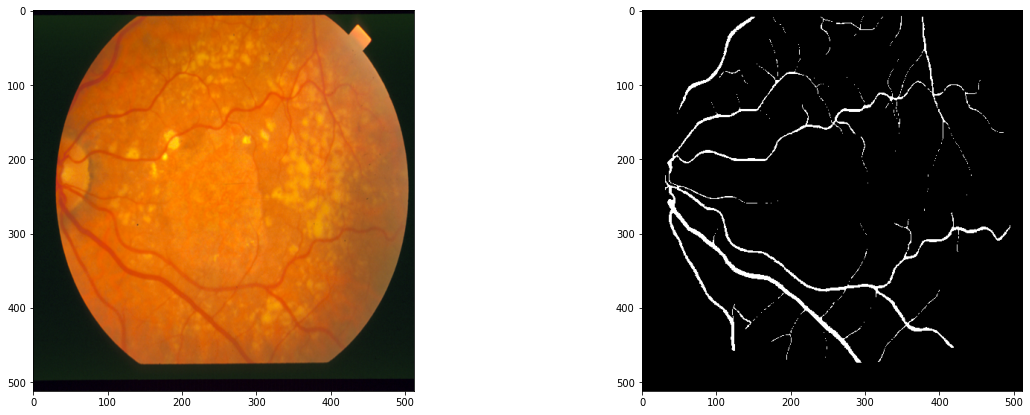

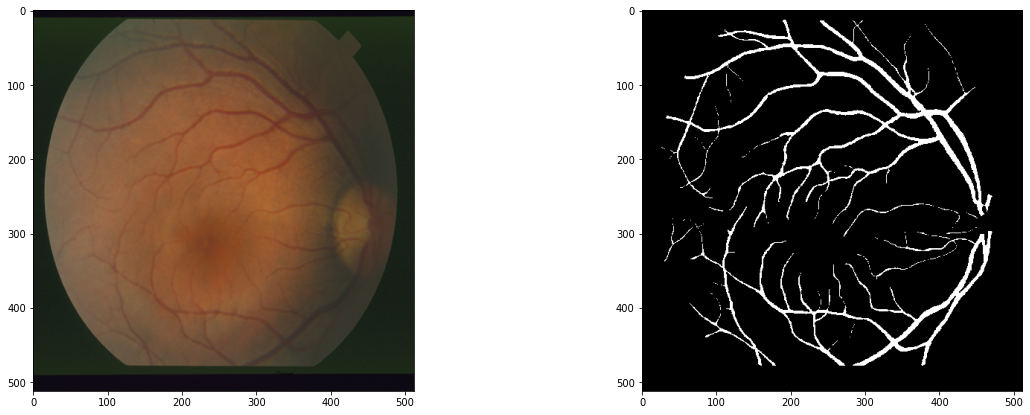

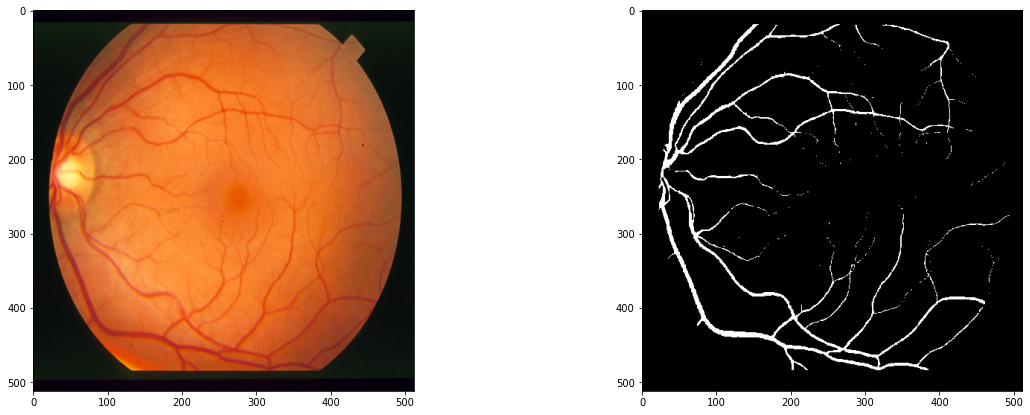

In [10]:
count=3
for data in data_generator:
    im, mask = data
    im=im.to(device)
    mask=mask.cpu().detach().numpy()
    mask=np.squeeze(mask, axis=0) 

    im=im.cpu().detach().numpy()
    im=np.squeeze(im, axis=0)    
    im=np.moveaxis(im, 0, -1)

    _,ax=plt.subplots(1,2, figsize=(20,7))
    ax=ax.ravel()
    ax[0].imshow(im)
    ax[1].imshow(mask, cmap='gray')
    plt.show()

    count-=1
    if count==0:
        break


# Model Definition

In [11]:
class Conv_Block(nn.Module):

	def __init__(self, in_channel, out_channel, activation):
		super().__init__()
		self.conv_1 = nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1)
		self.bn_1 = nn.BatchNorm2d(out_channel) 
  
		self.conv_2 = nn.Conv2d(out_channel, out_channel, kernel_size=3, padding=1)
		self.bn_2 = nn.BatchNorm2d(out_channel) 
  
		if activation=='relu':
			self.activation = nn.ReLU()     
		elif activation=='elu':
			self.activation = nn.ELU()  
		elif activation=='l_relu':
			self.activation = nn.LeakyReLU(negative_slope=0.1)
		else:
			raise Exception("Invalid Activation")

	def forward(self, x):
		x = self.conv_1(x)
		x = self.bn_1(x)
		x = self.activation(x)
		x = self.conv_2(x)
		x = self.bn_2(x)
		x = self.activation(x)
		return x
         

In [12]:
class Encoder_Unit(nn.Module):

	def __init__(self, in_channel, out_channel, activation):
		super().__init__()
		self.conv = Conv_Block(in_channel, out_channel, activation)
		self.pool = nn.MaxPool2d((2, 2))     
  
	def forward(self, x):
		c = self.conv(x)
		p = self.pool(c)
		return c, p


In [13]:
class Upsample_Block(nn.Module):

    def __init__(self, in_channel, out_channel, activation):
        super().__init__()
  
        self.up = nn.Upsample(scale_factor=2, mode='nearest')
        self.conv=nn.Conv2d(in_channel, out_channel, kernel_size=3, padding=1)
        self.bn = nn.BatchNorm2d(out_channel)  
        
        if activation=='relu':
            self.activation = nn.ReLU()     
        elif activation=='elu':
            self.activation = nn.ELU()  
        elif activation=='l_relu':
            self.activation = nn.LeakyReLU(negative_slope=0.1)
        else:
            raise Exception("Invalid Activation")
   
    def forward(self, x):
        x=self.up(x)
        x=self.conv(x)
        x=self.bn(x)
        x=self.activation(x)
        return x


In [14]:
class Decoder_Unit(nn.Module):

	def __init__(self, in_channel, out_channel, activation, up_mode="transpose"):
		super().__init__()
  
		if up_mode=='transpose':
			self.up = nn.ConvTranspose2d(in_channel, out_channel, kernel_size=2, stride=2, padding=0)
		elif up_mode=='upsample':
			self.up = Upsample_Block(in_channel, out_channel, activation)
		else:
			raise Exception("Invalid operation")
		self.conv = Conv_Block( 2*out_channel, out_channel, activation)     
		
	def forward(self, x, skip_connection):
		x = self.up(x)
		x = torch.cat([x, skip_connection], axis=1)
		x = self.conv(x)
		return x


In [15]:
class Unet(nn.Module):

	def __init__(self, activation='relu', up_mode='transpose'):
		super().__init__()

		self.e1 = Encoder_Unit(3, 64, activation)
		self.e2 = Encoder_Unit(64, 128, activation)
		self.e3 = Encoder_Unit(128, 256, activation)
		self.e4 = Encoder_Unit(256, 512, activation) 

		self.bottleneck = Conv_Block(512, 1024, activation) 
		
		self.d1 = Decoder_Unit(1024, 512, activation, up_mode)
		self.d2 = Decoder_Unit(512, 256, activation, up_mode)
		self.d3 = Decoder_Unit(256, 128, activation, up_mode)
		self.d4 = Decoder_Unit(128, 64, activation, up_mode) 
		
		self.outputs = nn.Conv2d(64, 1, kernel_size=1, padding=0)     
		self.sigmoid = nn.Sigmoid()

	def forward(self, x):
		s1, p1 = self.e1(x)
		s2, p2 = self.e2(p1)
		s3, p3 = self.e3(p2)
		s4, p4 = self.e4(p3) 
  
		b = self.bottleneck(p4) 
  
		d1 = self.d1(b, s4)
		d2 = self.d2(d1, s3)
		d3 = self.d3(d2, s2)
		d4 = self.d4(d3, s1) 
		outputs = self.outputs(d4)
		outputs = self.sigmoid(outputs)
		
		return outputs


# Model Creation

In [16]:
activation='relu'
up_mode='transpose'

In [17]:
model=Unet(activation, up_mode)
model.to(device)

Unet(
  (e1): Encoder_Unit(
    (conv): Conv_Block(
      (conv_1): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
    )
    (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  )
  (e2): Encoder_Unit(
    (conv): Conv_Block(
      (conv_1): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv_2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn_2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (activation): ReLU()
    )
    (pool): MaxPool2d(kerne

In [18]:
H,W

(512, 512)

In [19]:
summary(model, (3,H,W))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 512, 512]           1,792
       BatchNorm2d-2         [-1, 64, 512, 512]             128
              ReLU-3         [-1, 64, 512, 512]               0
            Conv2d-4         [-1, 64, 512, 512]          36,928
       BatchNorm2d-5         [-1, 64, 512, 512]             128
              ReLU-6         [-1, 64, 512, 512]               0
        Conv_Block-7         [-1, 64, 512, 512]               0
         MaxPool2d-8         [-1, 64, 256, 256]               0
      Encoder_Unit-9  [[-1, 64, 512, 512], [-1, 64, 256, 256]]               0
           Conv2d-10        [-1, 128, 256, 256]          73,856
      BatchNorm2d-11        [-1, 128, 256, 256]             256
             ReLU-12        [-1, 128, 256, 256]               0
           Conv2d-13        [-1, 128, 256, 256]         147,584
      BatchNorm2d-14    

# Training Code

In [20]:
def train(model, train_generator, criterion, optimizer, epoch, total_epochs, batch, bar):
    model.train()

    steps=len(train_generator)//batch

    for i, data in enumerate(train_generator, 0):
        img_batch, mask_batch = data
        img_batch=img_batch.to(device)
        mask_batch=mask_batch.to(device)

        optimizer.zero_grad()
        outputs = model(img_batch)
        loss = criterion(outputs, mask_batch)
        loss.backward()
        optimizer.step()

        loss_value = loss.item() 
        bar.update(i, values=[("loss", loss_value), ])

    return model


In [21]:
def evaluate(model, test_generator, criterion, bar):
    model.eval()

    running_loss=0.0

    for data in test_generator:
        img_batch, mask_batch = data
        img_batch=img_batch.to(device)
        mask_batch=mask_batch.to(device)        
        outputs = model(img_batch)
        loss = criterion(outputs, mask_batch)
        loss_value = loss.item() 
        bar.add(1, values=[("val_loss", loss_value), ])


In [22]:
class DiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(DiceLoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        
        # inputs = F.sigmoid(inputs)       
        
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1)
        
        intersection = (inputs * targets).sum()                            
        dice = (2.*intersection + smooth)/(inputs.sum() + targets.sum() + smooth)  
        
        return 1 - dice
        

In [23]:
class IoULoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super(IoULoss, self).__init__()

    def forward(self, inputs, targets, smooth=1):
        #flatten label and prediction tensors
        inputs = inputs.view(-1)
        targets = targets.view(-1).to(torch.float)
        
        #intersection is equivalent to True Positive count
        #union is the mutually inclusive area of all labels & predictions 
        intersection = (inputs * targets).sum()
        total = (inputs + targets).sum()
        union = total - intersection 
        
        IoU = (intersection + smooth)/(union + smooth)
                
        return 1 - IoU

# Training

In [24]:
total_epochs=100
steps=len(train_generator)//batch

criterion = DiceLoss()
# optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
optimizer = optim.Adam(model.parameters(), lr=1E-1)

In [25]:
for epoch in range(total_epochs):
    bar = pkbar.Kbar(target=steps, epoch=epoch, num_epochs=total_epochs, width=5, always_stateful=False, verbose=2)

    model = train(model, train_generator, criterion, optimizer, epoch, total_epochs, batch, bar)
    evaluate(model, test_generator, criterion, bar)

    if epoch==75:
        for par in optimizer.param_groups:
            par['lr'] = 1E-2

    if epoch==85:
        for par in optimizer.param_groups:
            par['lr'] = 1E-3

    if epoch==95:
        for par in optimizer.param_groups:
            par['lr'] = 1E-4


Epoch: 1/100
1/1 - 7s - loss: 0.9340
2/1 - 10s - loss: 0.9139
3/1 - 14s - loss: 0.9056
4/1 - 14s - loss: 0.9056 - val_loss: 0.8899
5/1 - 14s - loss: 0.9056 - val_loss: 0.9152
6/1 - 15s - loss: 0.9056 - val_loss: 0.9129
7/1 - 15s - loss: 0.9056 - val_loss: 0.9085
Epoch: 2/100
1/1 - 7s - loss: 0.8905
2/1 - 10s - loss: 0.8805
3/1 - 14s - loss: 0.8765
4/1 - 14s - loss: 0.8765 - val_loss: 0.8865
5/1 - 14s - loss: 0.8765 - val_loss: 0.9128
6/1 - 15s - loss: 0.8765 - val_loss: 0.9103
7/1 - 15s - loss: 0.8765 - val_loss: 0.9056
Epoch: 3/100
1/1 - 7s - loss: 0.8641
2/1 - 10s - loss: 0.8453
3/1 - 14s - loss: 0.8726
4/1 - 14s - loss: 0.8726 - val_loss: 0.8865
5/1 - 15s - loss: 0.8726 - val_loss: 0.9128
6/1 - 15s - loss: 0.8726 - val_loss: 0.9103
7/1 - 15s - loss: 0.8726 - val_loss: 0.9056
Epoch: 4/100
1/1 - 7s - loss: 0.9004
2/1 - 10s - loss: 0.8905
3/1 - 14s - loss: 0.9077
4/1 - 14s - loss: 0.9077 - val_loss: 0.8865
5/1 - 15s - loss: 0.9077 - val_loss: 0.9128
6/1 - 15s - loss: 0.9077 - val_loss:

# Testing

<b> diplay results on test data with order : (image, ground-truth mask, predicted mask) below</b>

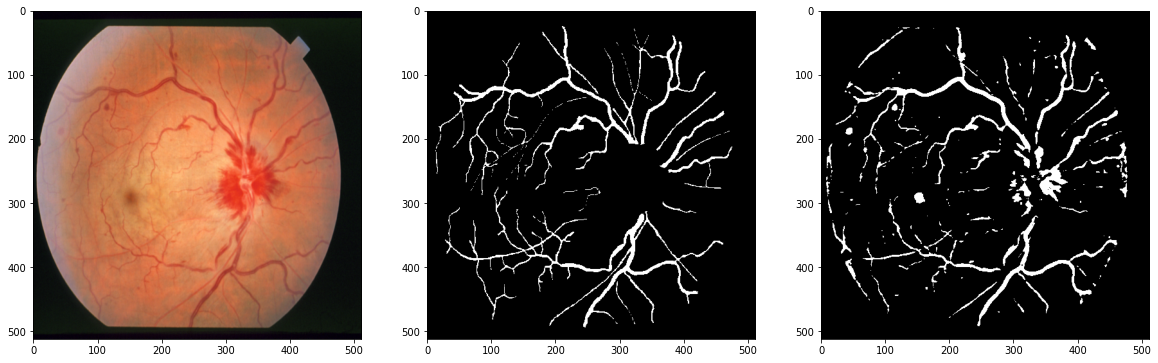

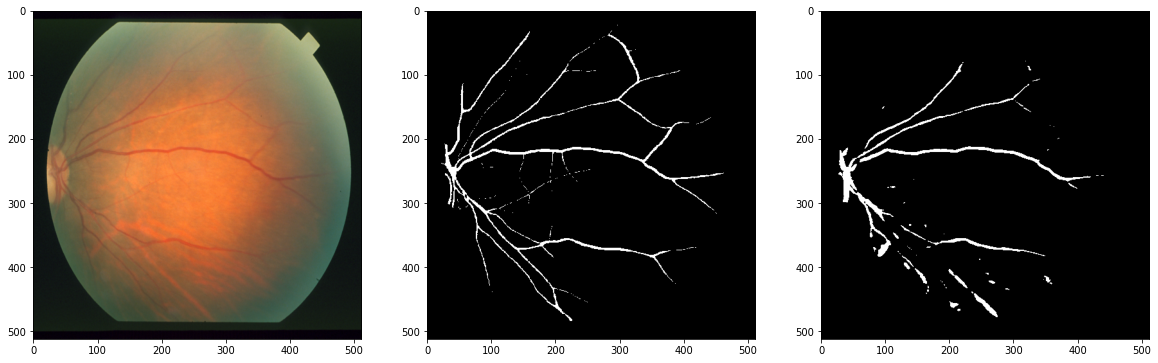

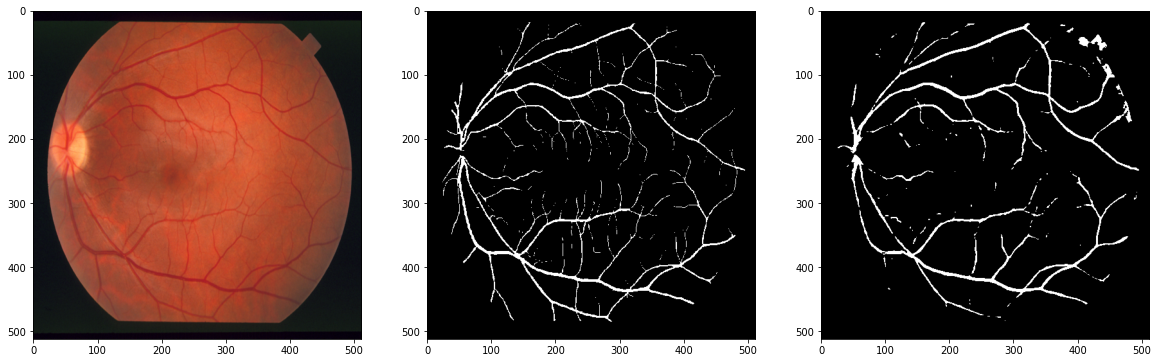

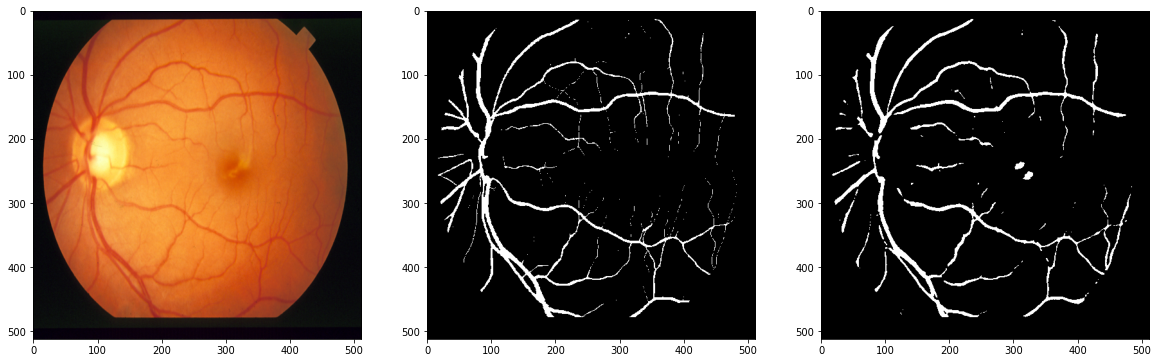

In [26]:
for data in test_generator:
    im, mask = data
    im=im.to(device)
    mask=mask.cpu().detach().numpy()
    mask=np.squeeze(mask, axis=0) 

    pred=model(im)
    pred[pred>0.5]=1
    pred[pred!=1]=0
    pred=pred.cpu().detach().numpy()
    pred=np.squeeze(pred)

    im=im.cpu().detach().numpy()
    im=np.squeeze(im, axis=0)    
    im=np.moveaxis(im, 0, -1)

    _,ax=plt.subplots(1,3, figsize=(20,7))
    ax=ax.ravel()
    ax[0].imshow(im)
    ax[1].imshow(mask, cmap='gray')
    ax[2].imshow(pred, cmap='gray')
    plt.show()
